#Linear Programming

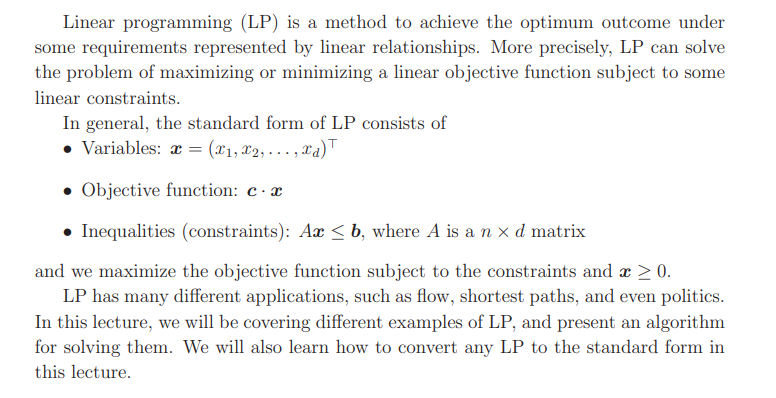

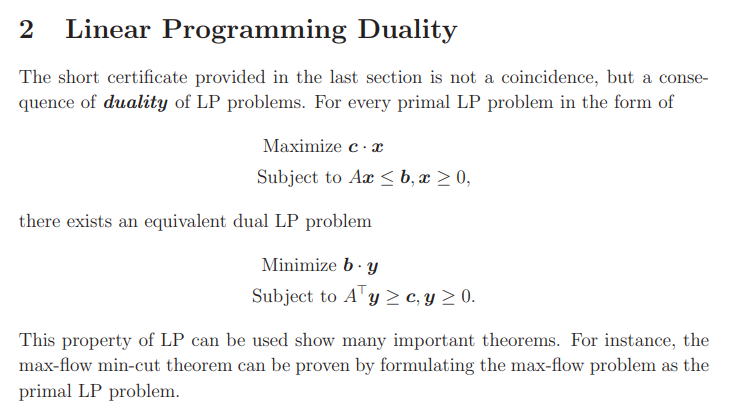

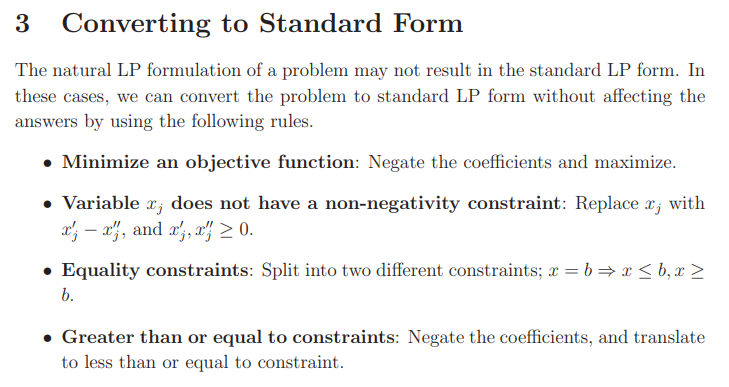

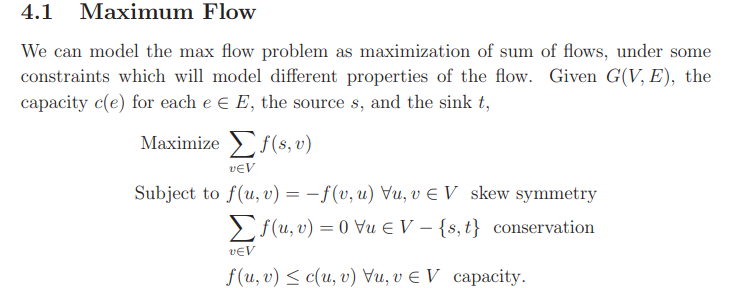

In [ ]:
%pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 29.9 MB/s eta 0:00:00


#Basic Maximum Flow Problem:


In [ ]:
import pulp

def maximum_flow(capacities, source, sink):
    """
    Solve the Maximum Flow problem using Linear Programming.

    Args:
        capacities (dict): Dictionary of dictionaries representing capacities.
                           capacities[u][v] gives the capacity from node u to node v.
        source: Source node.
        sink: Sink (or target) node.

    Returns:
        float: The maximum flow value from source to sink.
    """
    # Create a LP Minimization problem
    flow_lp = pulp.LpProblem("Maximum_Flow_LP", pulp.LpMaximize)

    # Define flow variables
    flow_vars = pulp.LpVariable.dicts("Flow", capacities.keys(), lowBound=0, cat='Continuous')

    # Objective function: maximize flow into sink
    flow_lp += pulp.lpSum(flow_vars[sink])

    # Constraints
    for node in capacities:
        for neighbor in capacities[node]:
            # Capacity constraint
            flow_lp += flow_vars[node] <= capacities[node][neighbor]
            # Flow conservation constraint
            flow_lp += flow_vars[node] - flow_vars[neighbor] <= capacities[node][neighbor]

    # Flow out of source must equal flow into sink
    flow_lp += pulp.lpSum(flow_vars[source]) == pulp.lpSum(flow_vars[sink])

    # Solve the LP problem
    flow_lp.solve()

    # Return the optimal objective value (maximum flow value)
    return pulp.value(flow_lp.objective)

# Example usage
if __name__ == "__main__":
    # Example graph: capacities as a dictionary of dictionaries
    capacities = {
        's': {'a': 10, 'b': 5},
        'a': {'t': 15},
        'b': {'a': 15, 't': 10},
        't': {}
    }

    source_node = 's'
    sink_node = 't'

    max_flow_value = maximum_flow(capacities, source_node, sink_node)
    print(f"Maximum Flow from {source_node} to {sink_node} is {max_flow_value}")

Maximum Flow from s to t is 5.0


#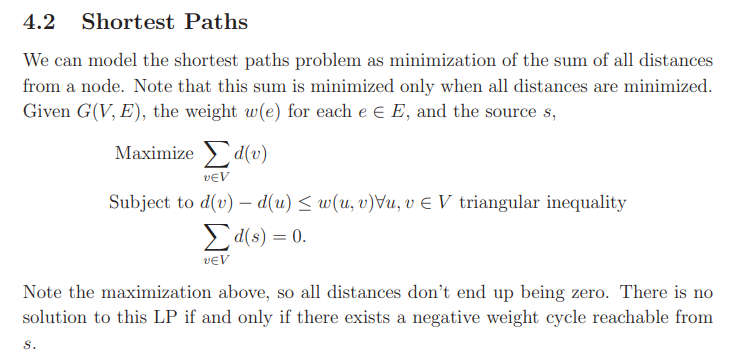

#Basic Shortest Paths Problem:


In [ ]:
import pulp

def shortest_path(graph, source, sink):
    """
    Solve the Shortest Path problem using Linear Programming.

    Args:
        graph (dict): Dictionary of dictionaries representing the graph.
                      graph[u][v] gives the weight (or cost) of the edge from node u to node v.
        source: Source node.
        sink: Sink (or target) node.

    Returns:
        float: The shortest path length from source to sink.
        list: The shortest path as a list of nodes.
    """
    # Create a LP Minimization problem
    shortest_path_lp = pulp.LpProblem("Shortest_Path_LP", pulp.LpMinimize)

    # Define variables: binary variable indicating whether edge (u, v) is selected
    edge_vars = pulp.LpVariable.dicts("Edge", (graph.keys(), graph.keys()), cat='Binary')

    # Objective function: minimize the total path length
    shortest_path_lp += pulp.lpSum(graph[u][v] * edge_vars[u][v] for u in graph for v in graph[u])

    # Constraints
    # Flow conservation constraints
    for node in graph:
        if node != source and node != sink:
            shortest_path_lp += pulp.lpSum(edge_vars[v][node] for v in graph if v != node) == \
                                 pulp.lpSum(edge_vars[node][v] for v in graph if v != node)

    # Flow out of source and into sink
    shortest_path_lp += pulp.lpSum(edge_vars[source][v] for v in graph[source]) - \
                         pulp.lpSum(edge_vars[v][source] for v in graph if v != source) == 1
    shortest_path_lp += pulp.lpSum(edge_vars[sink][v] for v in graph[sink]) - \
                         pulp.lpSum(edge_vars[v][sink] for v in graph if v != sink) == -1

    # Solve the LP problem
    shortest_path_lp.solve()

    # Extract shortest path length and path
    path = []
    current_node = source

    while current_node != sink:
        path.append(current_node)
        next_node_found = False
        for neighbor in graph[current_node]:
            if pulp.value(edge_vars[current_node][neighbor]) == 1:
                current_node = neighbor
                next_node_found = True
                break
        if not next_node_found:
            break

    # Append the sink node to the path
    path.append(sink)

    shortest_path_length = pulp.value(shortest_path_lp.objective)

    return shortest_path_length, path

# Example usage
if __name__ == "__main__":
    # Example graph: graph as a dictionary of dictionaries
    # Each key represents a node, and the value is a dictionary where the key is a neighbor and the value is the edge weight
    graph = {
        's': {'a': 2, 'b': 5},
        'a': {'t': 7},
        'b': {'a': 2, 't': 1},
        't': {}
    }

    source_node = 's'
    sink_node = 't'

    shortest_length, shortest_path = shortest_path(graph, source_node, sink_node)
    print(f"Shortest Path from {source_node} to {sink_node} has length {shortest_length}: {' -> '.join(shortest_path)}")


Shortest Path from s to t has length 3.0: s -> a -> t


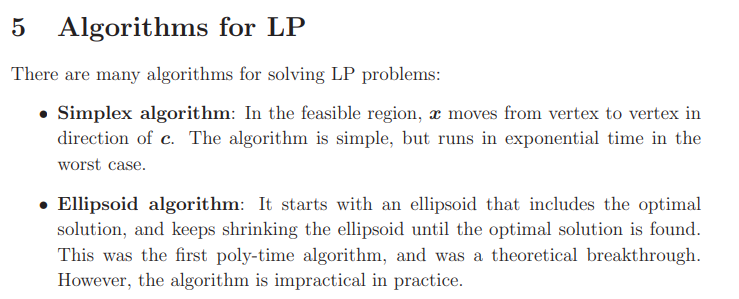

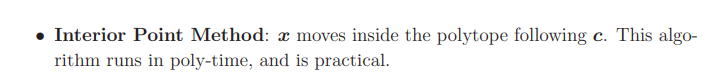

Source: https://github.com/hasan-kamal/Linear-Program-Solvers

#Simplex Solver:

In [ ]:
import numpy as np
import sympy
import itertools
from numpy.linalg import matrix_rank


class SimplexSolver:
	""" This class implements simplex algorithm to solve LPs """

	def solve(self, c, A, b):
		"""
		This method solves the std form LP min (c.T * x) s.t. Ax = b, x >= 0 using simplex algorithm.

		Parameters:
			c, A, b (np arrays): specify the LP in standard form

		Returns:
			-1 if LP is infeasible or optimal is (+-) infinity, else
			x (np array): solution to the LP
		"""

		# ensure dimensions are okay
		assert A.shape[0] == b.shape[0], 'first dims of A and b must match, check input!'
		assert A.shape[1] == c.shape[0], 'second dim of A must match first dim of c, check input!'

		# ensure A is full rank, drop redundant rows if not
		if matrix_rank(A) < min(A.shape[0], A.shape[1]):
			print('A is not full rank, dropping redundant rows')
			_, pivots = sympy.Matrix(A).T.rref()
			A = A[list(pivots)]
			print('Shape of A after dropping redundant rows is {}'.format(A.shape))

		self.A = A
		self.c = c
		self.b = b

		# define some frequently used parameters
		indices = list(range(self.A.shape[1]))

		# get the initial BFS (we will keep around the list of basic indices or basis matrix B as our current solution, instead of x explicitly)
		init_bfs = self.get_initial_bfs()
		if init_bfs is None:
			return -1
		(_, basic_indices) = init_bfs
		B = self.A[:, list(basic_indices)]
		optimal = False
		opt_infinity = False
		iteration_number = 0
		obj_val = float('inf')

		# main simplex body
		while not optimal:
			# print iteration number
			print('simplex: starting iteration #{}, obj = {}'.format(iteration_number, obj_val))
			iteration_number += 1

			# compute x_b, c_b, B_inv
			B_inv = np.linalg.inv(B)
			x_b = np.dot(B_inv, self.b)
			if (x_b == 0.0).any():
				print('simplex: alert! this bfs is degenerate')
			c_b = self.c[basic_indices]

			if iteration_number == 1:
				print('initial x_b = {}, with basic_indices = {}'.format(x_b, basic_indices))

			# compute obj_val just for display purposes
			obj_val = 0.0
			for i, b_i in enumerate(basic_indices):
				obj_val += (c[b_i] * x_b[i])

			# compute reduced cost in each non-basic j-th direction
			reduced_costs = {}
			for j in indices:
				if j not in basic_indices:
					# j is a non-basic index
					A_j = self.A[:, j]
					reduced_costs[j] = self.c[j] - np.dot(c_b.T, np.dot(B_inv, A_j))

			float_values = [float(value) for value in reduced_costs.values()]

			# check if this solution is optimal
			if all(value >= 0.0 for value in float_values):
				# all reduced costs are >= 0.0 so this means we are at optimal already
				optimal = True
				break


			# this solution is not optimal, go to a better neighbouring BFS
			chosen_j = None
			for j in reduced_costs.keys():
				if reduced_costs[j] < 0.0:
					chosen_j = j
					break

			d_b = -1.0 * np.dot(B_inv, self.A[:, chosen_j])
			# check if optimal is infinity
			if (d_b >= 0).all():
				# optimal is -infinity
				opt_infinity = True
				break

			# calculate theta_star and the exiting index l
			l = None
			theta_star = None
			for i, basic_index in enumerate(basic_indices):
				if d_b[i] < 0:
					if l is None:
						l = i
					if -x_b[i]/d_b[i] < -x_b[l]/d_b[l]:
						l = i
						theta_star = -x_b[i]/d_b[i]

			# form new solution by replacing basic_indices[l] with chosen_j
			basic_indices[l] = chosen_j
			basic_indices.sort()
			B = self.A[:, list(basic_indices)]


		if opt_infinity:
			print('Optimal is inifinity')
			return -1

		if not optimal:
			print('optimal not found')
			return -1

		# return solution
		x = np.zeros(shape=(self.A.shape[1], ))
		for i in range(x.shape[0]):
			if i in basic_indices:
				x[i] = x_b[basic_indices.index(i)]
		return x


	def get_initial_bfs(self):
		"""
		This is a helper method used by solve() method to compute the initial basic feasible solution (BFS) required by simplex algorithm.
		It uses the auxiliary LP technique to compute such a BFS.

		Parameters:
			None

		Returns:
			None if the original LP is infeasible, else
			Tuple (B, basic_indices) where
				-> B 			(np array): basis matrix of the BFS
				-> basic_indices    (list): list of basic indices of the BFS
		"""

		M = self.A.shape[0]
		N = self.A.shape[1]

		# new constraint matrix A_ and c, b vector (b >= 0 must hold, so multiply by -1 if not already)
		A_positive = np.copy(self.A)
		b = np.copy(self.b)
		for i in range(M):
			if b[i] < 0.0:
				b[i] = -1.0 * b[i]
				A_positive[i, :] = -1 * A_positive[i, :]

		A_ = np.concatenate((A_positive, np.eye(M)), axis=1)
		c = np.zeros(shape=(N + M, ))
		for i in range(N, N + M):
			c[i] = 1.0
		indices = list(range(N + M))

		# variables: [ x_0, ..., x_N-1, y_0, ..., y_M-1 ]
		# init bfs of aux problem is x = 0, y = b
		# so basic initial indices for aux problem are (N, ..., N + M - 1)
		basic_indices = list(range(N, N + M))
		B = A_[:, basic_indices]

		optimal = False
		opt_infinity = False
		iteration_number = 0
		obj_val = float('inf')

		# main simplex body
		while not optimal:

			# print iteration number
			print('get_init_bfs_aux: starting iteration #{}, obj = {}'.format(iteration_number, obj_val))
			iteration_number += 1

			# compute x_b, c_b, B_inv
			B_inv = np.linalg.inv(B)
			x_b = np.dot(B_inv, b)
			if (x_b == 0.0).any():
				print('get_init_bfs_aux: alert! this bfs is degenerate')
			c_b = c[basic_indices]

			# compute obj_val just for display purposes
			obj_val = 0.0
			for i, b_i in enumerate(basic_indices):
				obj_val += (c[b_i] * x_b[i])

			# compute reduced cost in each non-basic j-th direction
			reduced_costs = {}
			for j in indices:
				if j not in basic_indices:
					# j is a non-basic index
					A_j = A_[:, j]
					reduced_costs[j] = c[j] - np.dot(c_b.T, np.dot(B_inv, A_j))

			float_array = np.array([float(value) for value in reduced_costs.values()])

			# check if this solution is optimal
			if (float_array >= 0.0).all():
				# all reduced costs are >= 0.0 so this means we are at optimal already
				optimal = True
				break

			# this solution is not optimal, go to a better neighbouring BFS
			chosen_j = None
			for j in reduced_costs.keys():
				if reduced_costs[j] < 0.0:
					chosen_j = j
					break

			d_b = -1.0 * np.dot(B_inv, A_[:, chosen_j])
			# check if optimal is infinity
			if (d_b >= 0).all():
				# optimal is -infinity
				opt_infinity = True
				break

			# calculate theta_star and the exiting index l
			l = None
			theta_star = None
			for i, basic_index in enumerate(basic_indices):
				if d_b[i] < 0:
					if l is None:
						l = i
					if -x_b[i]/d_b[i] < -x_b[l]/d_b[l]:
						l = i
						theta_star = -x_b[i]/d_b[i]

			# form new solution by replacing basic_indices[l] with chosen_j
			basic_indices[l] = chosen_j
			basic_indices.sort()
			B = A_[:, list(basic_indices)]


		if obj_val != 0.0:
			print('get_init_bfs_aux: the original problem is infeasible!')
			return None

		# if basic_indices contains no artifical variables, return that
		contains_artifical = False
		for x in basic_indices:
			if x >= N:
				contains_artifical = True
				break
		if not contains_artifical:

			assert len(basic_indices) == M, 'assertion failed, please check this'
			assert matrix_rank(B) == M, 'this should have been equal, assertion failed'
			x_b = np.dot(np.linalg.inv(B), b)
			assert (x_b >= 0.0).all(), 'this does not give a feasible solution, something is wrong, assertion failed'
			print('init_bfs_aux: assertions passed, no artificial vars in basis by chance! found a valid init bfs in {} iterations'.format(iteration_number))
			basic_indices.sort()

			return (B, basic_indices)

		# basis contains artificial variables
		basic_indices_no_artificial = []
		for index in basic_indices:
			if index < N:
				basic_indices_no_artificial.append(index)

		# now have to choose columns from A that are linearly independent to the current selection of basis indices
		counter = 0
		while len(basic_indices_no_artificial) < M:
			if counter in basic_indices_no_artificial:
				continue

			# check if counter-th column of A is linearly independent with current selection of indices
			B_small = self.A[:, basic_indices_no_artificial]
			B_test = np.concatenate((B_small, self.A[:, counter]), axis=1)
			if matrix_rank(B_test) == min(B_test.shape[0], B_test.shape[1]):
				# is l.i., so take this column
				basic_indices_no_artificial.append(counter)

			counter += 1

		# test if what we got is indeed a BFS to original problem
		basic_indices = basic_indices_no_artificial
		basic_indices.sort()
		B = self.A[:, basic_indices]

		assert len(basic_indices) == M, 'assertion failed, please check this'
		assert matrix_rank(B) == M, 'this should have been equal, assertion failed'
		x_b = np.dot(np.linalg.inv(B), b)
		assert (x_b >= 0.0).all(), 'this does not give a feasible solution, something is wrong, assertion failed'
		print('init_bfs_aux: assertions passed! found a valid init bfs in {} iterations'.format(iteration_number))

		return (B, basic_indices)

#Interior Point Method:

In [ ]:
import numpy as np
import sympy
from numpy.linalg import matrix_rank


class InteriorPointSolver:
	""" This class implements primal-dual (infeasible) interior-point method to solve LPs """

	def solve(self, c, A, b, epsilon=0.0001):
		"""
		This method solves the std form LP min (c.T * x) s.t. Ax = b, x >= 0 using primual-dual (infeasible) interior-point method.

		Parameters:
			c, A, b (np arrays): specify the LP in standard form
			epsilon		(float): duality gap threshold, specifies termination criteria

		Returns:
			x 		(np array): solution to the LP
		"""

		# ensure dimensions are okay
		assert A.shape[0] == b.shape[0], 'first dims of A and b must match, check input!'
		assert A.shape[1] == c.shape[0], 'second dim of A must match first dim of c, check input!'

		# ensure A is full rank, drop redundant rows if not
		if matrix_rank(A) < min(A.shape[0], A.shape[1]):
			print('A is not full rank, dropping redundant rows')
			_, pivots = sympy.Matrix(A).T.rref()
			A = A[list(pivots)]
			print('Shape of A after dropping redundant rows is {}'.format(A.shape))

		m = A.shape[0]
		n = A.shape[1]

		# initial solution (x_0, lambda_0, s_0) > 0 [lambda is variable l in code]
		# note that this is not a feasible solution in general
		# but it should tend towards feasibility by itself with iterations
		# therefore initially duality gap might show negative
		# since this is the infeasible-interior-point algorithm
		x = np.ones(shape=(n, ))
		l = np.ones(shape=(m, ))
		s = np.ones(shape=(n, ))

		# set iteration counter to 0 and mu_0
		k = 0

		# main loop body
		while abs(np.dot(x, s)) > epsilon:

			# print iteration number and progress
			k += 1
			primal_obj = np.dot(c, x)
			dual_obj = np.dot(b, l)
			print('iteration #{}; primal_obj = {:.5f}, dual_obj = {:.5f}; duality_gap = {:.5f}'.format(k, primal_obj, dual_obj, primal_obj - dual_obj))

			# choose sigma_k and calculate mu_k
			sigma_k = 0.4
			mu_k = np.dot(x, s) / n

			# create linear system A_ * delta = b_
			A_ = np.zeros(shape=(m + n + n, n + m + n))
			A_[0:m, 0:n] = np.copy(A)
			A_[m:m + n, n:n + m] = np.copy(A.T)
			A_[m:m + n, n + m:n + m + n] = np.eye(n)
			A_[m + n:m + n + n, 0:n] = np.copy(np.diag(s))
			A_[m + n:m + n + n, n + m:n + m + n] = np.copy(np.diag(x))

			b_ = np.zeros(shape=(n + m + n, ))
			b_[0:m] = np.copy(b - np.dot(A, x))
			b_[m:m + n] = np.copy(c - np.dot(A.T, l) - s)
			b_[m + n:m + n + n] = np.copy( sigma_k * mu_k * np.ones(shape=(n, )) - np.dot(np.dot(np.diag(x), np.diag(s)), np.ones(shape=(n, ))) )

			# solve for delta
			delta = np.linalg.solve(A_, b_)
			delta_x = delta[0:n]
			delta_l = delta[n:n + m]
			delta_s = delta[n + m:n + m + n]

			# find step-length alpha_k
			alpha_max = 1.0
			for i in range(n):
				if delta_x[i] < 0:
					alpha_max = min(alpha_max, -x[i]/delta_x[i])
				if delta_s[i] < 0:
					alpha_max = min(alpha_max, -s[i]/delta_s[i])
			eta_k = 0.99
			alpha_k = min(1.0, eta_k * alpha_max)

			# create new iterate
			x = x + alpha_k * delta_x
			l = l + alpha_k * delta_l
			s = s + alpha_k * delta_s

		# print difference between Ax and b
		diff = np.dot(A, x) - b
		print('Ax - b = {}; ideally it should have been zero vector'.format(diff))
		print('norm of Ax - b is = {}; ideally it should have been zero'.format(np.linalg.norm(diff)))

		return x

#Brute-Force Solver

In [ ]:
import numpy as np
import itertools
from numpy.linalg import matrix_rank


class BruteSolver:
	""" This class implements brute-force exhaustive search (try all possible bases) to solve LPs """

	def solve(self, c, A, b):
		"""
		This method solves the std form LP min (c.T * x) s.t. Ax = b, x >= 0 using brute-force exhaustive search (try all possible bases).

		Parameters:
			c, A, b (np arrays): specify the LP in standard form

		Returns:
			-1 if LP is infeasible or optimal is (+-) infinity, else
			x (np array): solution to the LP
		"""

		# ensure dimensions are okay
		assert A.shape[0] == b.shape[0], 'first dims of A and b must match, check input!'
		assert A.shape[1] == c.shape[0], 'second dim of A must match first dim of c, check input!'

		# ensure A is full rank, drop redundant rows if not
		if matrix_rank(A) < min(A.shape[0], A.shape[1]):
			print('A is not full rank, dropping redundant rows')
			_, pivots = sympy.Matrix(A).T.rref()
			A = A[list(pivots)]
			print('Shape of A after dropping redundant rows is {}'.format(A.shape))

		# try all possible basis matrices (i.e. all m-combinations of basic indices) and take best
		m = A.shape[0]
		indices = list(range(A.shape[1]))
		opt_basis = None
		opt_val = float('inf')
		opt_xb = None

		# main loop body
		iteration_number = 0
		for basic_indices in itertools.combinations(indices, m):
			iteration_number += 1

			B = A[:, list(basic_indices)]
			if matrix_rank(B) != m:
					continue
			x_b = np.dot(np.linalg.inv(B), b)

			if (x_b < 0.0).any():
				# infeasible
				continue

			obj = 0.0
			for i, b_i in enumerate(basic_indices):
				obj += (c[b_i] * x_b[i])

			if obj < opt_val:
				opt_val = obj
				opt_basis = basic_indices
				opt_xb = x_b

		# show how many iterations it took
		print('brute took {} iterations'.format(iteration_number))

		# infeasible LP
		if opt_basis is None:
			return -1

		# return optimal solution
		x = np.zeros(shape=(A.shape[1], ))
		for i in range(x.shape[0]):
			if i in opt_basis:
				x[i] = opt_xb[opt_basis.index(i)]
		return x

In [ ]:
import numpy as np


def network_flow_to_std_LP(G, s, t):
	"""
	This function converts a given network (max-)flow problem into a std form LP min (c.T * x) s.t. Ax = b, x >= 0

	Parameters:
		G (np array): weighted adjacency matrix of graph where G[i][j] denotes capacity of directed edge i->j
		s 	   (int): source vertex, 0-based indexing
		t 	   (int): sink vertex, 0-based indexing

	Returns:
		c, A, b (np arrays): specify the LP in std form
		id_to_edge 	  (map): mapping from edge ids to edges
	"""

	N = len(G)
	edges = []
	id_to_edge = {}
	edge_to_id = {}
	num_edges = 0

	# dictionaries that hold list of in and out nbours of each node
	in_nbours = {}
	out_nbours = {}

	for i in range(N):
		for j in range(N):
			# skip this edge if not present
			if G[i][j] == 0:
				continue

			if i not in out_nbours:
				out_nbours[i] = []
			out_nbours[i].append(j)

			if j not in in_nbours:
				in_nbours[j] = []
			in_nbours[j].append(i)

			# edge i -> j exists
			edge = (i, j)
			edges.append(edge)
			id_to_edge[num_edges] = edge
			edge_to_id[edge] = num_edges
			num_edges += 1

	# we have a slack variable also corresponding to each edge (needed for capacity constraint)
	# first we embed flow variables, then slack variables
	num_variables = 2 * num_edges

	# create c
	c = np.zeros(shape=(num_variables, ))
	for i in range(num_edges):
		edge = id_to_edge[i]
		if edge[0] == s:
			# this edge exits s
			# so this variable should be present in c
			c[i] = -1.0

	# create A, b matrices
	# first we embed num_edges # of capacity constraints
	# then we embed N - 2 conservation constraints
	num_rows = num_edges + N - 2
	A = np.zeros(shape=(num_rows, num_variables))
	b = np.zeros(shape=(num_rows, ))

	# embed num_edges # of capacity constraints
	for i in range(num_edges):
		edge = id_to_edge[i]
		A[i, i] = 1.0 # add flow variable to constraint
		A[i, i + num_edges] = 1.0 # add slack variable to constrain
		b[i] = G[edge[0]][edge[1]]

	# we embed N - 2 conservation constraints
	num_non_terminal_nodes = 0
	for i in range(N):
		if i == s or i == t:
			continue

		# out neighbours
		for out_nbour in out_nbours[i]:
			A[num_edges + num_non_terminal_nodes, edge_to_id[(i, out_nbour)]] = 1.0

		# in neighbours
		for in_nbour in in_nbours[i]:
			A[num_edges + num_non_terminal_nodes, edge_to_id[(in_nbour, i)]] = -1.0

		# handle self-loop
		if (i, i) in edge_to_id:
			A[num_edges + num_non_terminal_nodes, edge_to_id[(i, i)]] = 0

		b[num_edges + num_non_terminal_nodes] = 0.0
		num_non_terminal_nodes += 1

	return c, A, b, id_to_edge


def primal_to_dual(c, A, b):
	"""
	This function returns dual (in std form) of a primal LP (which is also provided in std form)

	Parameters:
		c, A, b       (np arrays): specify the primal LP in std form
		c_d, A_d, b_d (np arrays): corresponding dual LP in std form
	"""

	# the dual is min b.T * y subject to A.T * y + c >= 0
	# we need to convert it into standard form by adding slack variables and also we have to handle that y is a free variable
	M = b.shape[0]
	N = c.shape[0]

	# we represent y as y1 - y2 to handle y being a free variable
	# we embed variables as follows: (y1_0, ..., y1_M-1, y2_0, ..., y2_M-1, s_0, ..., s_N-1)
	# where s are slack variables
	c_d = np.zeros(shape=(2 * M + N, ))
	for i in range(M):
		c_d[i] = b[i]
		c_d[i + M] = -b[i]

	b_d = -1 * c
	A_d = np.concatenate((A.T, -1 * A.T, -1 * np.eye(N)), axis=1)

	return c_d, A_d, b_d

In [ ]:
if __name__ == '__main__':

	# Test 1, max-flow problem, small graph
	print('\nTest #1')
	G = np.array([
			[0, 16, 13,  0,  0, 0 ],
			[0,  0, 10, 12,  0, 0 ],
			[0,  4,  0,  0, 14, 0 ],
			[0,  0,  9,  0,  0, 20],
			[0,  0,  0,  7,  0, 7 ],
			[0,  0,  0,  0,  0, 0 ]
		])

	# convert max-flow problem into std LP form
	c, A, b, id_to_edge = network_flow_to_std_LP(G, s=0, t=5)

	# solve LP using simplex algorithm
	solver = SimplexSolver()
	x = solver.solve(c, A, b)

	# show optimal objective value, max-flow of original problem and display optimal edge flows
	opt_obj = np.dot(c, x)
	print('Optimal objective value 	= {}'.format(opt_obj))
	print('Max flow from s -> t 		= {}'.format(-opt_obj))
	print('Optimal edge flows: \n')
	for i in id_to_edge.keys():
		a1, a2 = id_to_edge[i]
		print('Edge ({:1}, {:2}) = {:6.2f} / {:2}'.format(a1, a2, x[i], G[a1][a2]))



	# Test 2, max-flow problem, large graph
	print('\nTest #2')
	G = np.array([
			[0, 11, 15, 10, 0,  0, 0,  0,  0,  0, 0,  0],
			[0,  0,  0,  0, 0, 18, 4,  0,  0,  0, 0,  0],
			[0,  3,  8,  5, 0,  0, 0,  0,  0,  0, 0,  0],
			[0,  0,  0,  0, 6,  0, 0,  3, 11,  0, 0,  0],
			[0,  0,  0,  4, 0,  0, 0, 17,  6,  0, 0,  0],
			[0,  0,  0,  0, 3, 16, 0,  0,  0, 13, 0,  0],
			[0, 12,  0,  0, 4,  0, 0,  0,  0,  0, 0, 21],
			[0,  0,  0,  0, 0,  0, 0,  0,  4,  9, 4,  3],
			[0,  0,  0,  0, 0,  0, 0,  4,  0,  0, 5,  4],
			[0,  0,  0,  0, 0,  0, 0,  0,  0,  0, 7,  9],
			[0,  0,  0,  0, 0,  0, 0,  0,  2,  0, 0, 15],
			[0,  0,  0,  0, 0,  0, 0,  0,  0,  0, 0,  0]
		])

	# convert max-flow problem into std LP form
	c, A, b, id_to_edge = network_flow_to_std_LP(G, s=0, t=11)

	# solve LP using interior-point method
	solver = InteriorPointSolver()
	epsilon = 1e-4
	x = solver.solve(c, A, b, epsilon)

	# show optimal objective value, max-flow of original problem and display optimal edge flows
	opt_obj = np.dot(c, x)
	print('Optimal objective value 	= {}'.format(opt_obj))
	print('Max flow from s -> t 		= {}'.format(-opt_obj))
	print('Optimal edge flows: \n')
	for i in id_to_edge.keys():
		a1, a2 = id_to_edge[i]
		print('Edge ({:2}, {:2}) = {:6.2f} / {:2}'.format(a1, a2, x[i], G[a1][a2]))

	# Test 3, max-flow problem, small graph
	print('\nTest #3')
	G = np.array([
			[0, 16, 13,  0,  0, 0 ],
			[0,  0, 10, 12,  0, 0 ],
			[0,  4,  0,  0, 14, 0 ],
			[0,  0,  9,  0,  0, 20],
			[0,  0,  0,  7,  0, 7 ],
			[0,  0,  0,  0,  0, 0 ]
		])

	# convert max-flow problem into std LP form
	c, A, b, id_to_edge = network_flow_to_std_LP(G, s=0, t=5)

	# solve LP using simplex algorithm
	solver = BruteSolver()
	x = solver.solve(c, A, b)

	# show optimal objective value, max-flow of original problem and display optimal edge flows
	opt_obj = np.dot(c, x)
	print('Optimal objective value 	= {}'.format(opt_obj))
	print('Max flow from s -> t 		= {}'.format(-opt_obj))
	print('Optimal edge flows: \n')
	for i in id_to_edge.keys():
		a1, a2 = id_to_edge[i]
		print('Edge ({:1}, {:2}) = {:6.2f} / {:2}'.format(a1, a2, x[i], G[a1][a2]))



Test #1
get_init_bfs_aux: starting iteration #0, obj = inf
get_init_bfs_aux: alert! this bfs is degenerate
get_init_bfs_aux: starting iteration #1, obj = 112.0
get_init_bfs_aux: alert! this bfs is degenerate
get_init_bfs_aux: starting iteration #2, obj = 112.0
get_init_bfs_aux: alert! this bfs is degenerate
get_init_bfs_aux: starting iteration #3, obj = 102.0
get_init_bfs_aux: alert! this bfs is degenerate
get_init_bfs_aux: starting iteration #4, obj = 96.0
get_init_bfs_aux: alert! this bfs is degenerate
get_init_bfs_aux: starting iteration #5, obj = 88.0
get_init_bfs_aux: starting iteration #6, obj = 82.0
get_init_bfs_aux: starting iteration #7, obj = 74.0
get_init_bfs_aux: starting iteration #8, obj = 66.0
get_init_bfs_aux: starting iteration #9, obj = 62.0
get_init_bfs_aux: starting iteration #10, obj = 54.0
get_init_bfs_aux: starting iteration #11, obj = 33.0
get_init_bfs_aux: alert! this bfs is degenerate
get_init_bfs_aux: starting iteration #12, obj = 19.0
get_init_bfs_aux: aler

#Ellipsoid Solver

In [ ]:
import numpy as np
import scipy.linalg as la

class EllipsoidSolver:
    """ This class implements the Ellipsoid Algorithm to solve LPs """

    def solve(self, c, A, b, max_iters=1000, tol=1e-6):
        """
        This method solves the LP min (c.T * x) s.t. Ax = b, x >= 0 using the Ellipsoid Algorithm.

        Parameters:
            c (np.array): Coefficients of the objective function to be minimized.
            A (np.array): Constraint matrix of the linear system.
            b (np.array): Right-hand side vector of the linear system.
            max_iters (int): Maximum number of iterations.
            tol (float): Tolerance for convergence.

        Returns:
            x (np.array): Solution to the LP if successful, else None.
        """
        n = len(c)  # Dimension of the problem

        try:
            # Print matrix A and its rank
            print("Constraint matrix A:")
            print(A)
            print("Rank of A:", np.linalg.matrix_rank(A))

            # Initialize ellipsoid
            D = 1.0  # Initial radius of the ellipsoid
            x_center = np.zeros(n)  # Initial center of the ellipsoid

            for k in range(max_iters):
                # Step 2: Compute the center of the ellipsoid
                x = x_center + np.dot(A.T, np.linalg.solve(A.dot(A.T), b - A.dot(x_center)))

                # Step 3: Compute the volume of the ellipsoid
                V = (np.pi**(n/2) / la.det(A.dot(A.T))**(1/2)) * D**n

                # Step 4: Check if the current ellipsoid contains a feasible solution
                if np.linalg.norm(A.dot(x) - b) < tol:
                    return x

                # Step 5: Update the ellipsoid
                D = D / 2  # Decrease the radius
                x_center = x  # Update the center of the ellipsoid

        except np.linalg.LinAlgError as e:
            print(f"Error: {e}")

        # If max_iters is reached without finding a solution
        print("Ellipsoid Algorithm did not converge to a solution.")
        return None

# Example usage with a new constraint matrix
if __name__ == "__main__":
    c = np.array([1, 1])  # Coefficients of the objective function
    A = np.array([[1, 1], [1, -1]])  # Constraint matrix
    b = np.array([2, 1])  # Right-hand side vector

    solver = EllipsoidSolver()
    solution = solver.solve(c, A, b)

    if solution is not None:
        print("Optimal solution:", solution)
    else:
        print("No solution found.")


Constraint matrix A:
[[ 1  1]
 [ 1 -1]]
Rank of A: 2
Optimal solution: [1.5 0.5]
